# Simple skill assessment for HydroTas 2020-2021 workplan:
- rainfall, surface temp and surface wind over Australia region and Tasmania region
- Assess skill as function of start month and ensemble size

In [1]:
import sys
sys.path.insert(0, '/OSM/CBR/OA_DCFP/work/squ027/software/xskillscore')

import xarray as xr
import myfuncs as my
import xskillscore as xs

# Parameters

In [439]:
CLIM_PERIOD = slice('1990-01-01', '2019-12-31')
TEST_PERIOD = slice('1990-01-01', '2019-12-31')
PARAMS = {'precip': 
             {'obsv_file': 'data/awap_precip_{region}.zarr',
              'fcst_file': 'data/f6_precip_{region}.zarr'},
          't_ref':
             {'obsv_file': 'data/jra55_t_ref_{region}.zarr',
              'fcst_file': 'data/f6_t_ref_{region}.zarr'},
          'V_ref':
             {'obsv_file': 'data/jra55_V_ref_{region}.zarr',
              'fcst_file': 'data/f6_V_ref_{region}.zarr'}}

# Perform skill assessment using CRPSS

In [514]:
fcst = my.open_zarr('data/f6_t_ref_AUS_anom.zarr').compute()
obsv = my.open_zarr('data/jra55_t_ref_AUS_anom.zarr').compute()

In [522]:
start_months = np.unique(fcst.init_date.dt.month)
start_month = start_months[1]

In [523]:
keep_mon = obsv.init_date.dt.month == start_month
fcst_mon = fcst.where(keep_mon, drop=True)
obsv_mon = obsv.where(keep_mon, drop=True)

In [524]:
def get_climatological_probabilities(obsv, period):
    def _init_date_to_ensemble(ds):
        """ Collapse all available init_dates at a given lead into a new ensemble dimension"""
        ds_drop = ds.copy().dropna('init_date')
        ds_drop = ds_drop.rename({'init_date': 'ensemble'})
        return ds_drop.assign_coords({'ensemble': range(len(ds_drop['ensemble']))})
    obsv_period = my.mask_time_period(obsv, period=period)
    obsv_ensemble = obsv_period.groupby('lead_time').map(_init_date_to_ensemble)
    clim_prob = obsv_ensemble.broadcast_like(obsv)
    return clim_prob.assign_coords({'time': obsv['time']})

In [525]:
clim_probs_mon = get_climatological_probabilities(obsv_mon, CLIM_PERIOD)

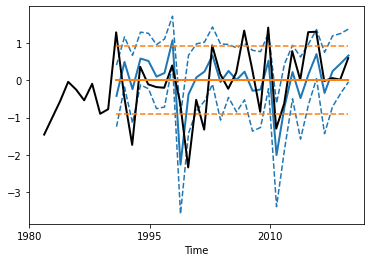

In [529]:
import matplotlib.pyplot as plt

lead = 0
variable = 't_ref'

std = my.mask_time_period(
    fcst_mon.std('ensemble')[variable].isel(lead_time=lead),
    TEST_PERIOD)
mean = my.mask_time_period(
    fcst_mon.mean('ensemble')[variable].isel(lead_time=lead),
    TEST_PERIOD)
plt.plot(mean.time, (mean - std), color='C0', linestyle='--')
plt.plot(mean.time, (mean + std), color='C0', linestyle='--')
plt.plot(mean.time, mean, color='C0', linewidth=2)

ref = obsv_mon[variable].isel(lead_time=lead)
plt.plot(ref.time, ref, color='k', linewidth=2)

std = my.mask_time_period(
    clim_probs_mon.std('ensemble')[variable].isel(lead_time=lead),
    TEST_PERIOD)
mean = my.mask_time_period(
    clim_probs_mon.mean('ensemble')[variable].isel(lead_time=lead),
    TEST_PERIOD)
plt.plot(mean.time, (mean - std).where(ref.notnull()), color='C1', linestyle='--')
plt.plot(mean.time, (mean + std).where(ref.notnull()), color='C1', linestyle='--')
plt.plot(mean.time, mean.where(ref.notnull()), color='C1', linewidth=2)

plt.xlabel('Time');

In [527]:
def crpss(obsv, fcst, fcst_baseline, period):
    crps = xs.crps_ensemble(
        my.mask_time_period(obsv, period=period),
        my.mask_time_period(fcst, period=period),
        member_dim='ensemble',
        dim='init_date')
    baseline = xs.crps_ensemble(
        my.mask_time_period(obsv, period=period),
        my.mask_time_period(fcst_baseline, period=period),
        member_dim='ensemble',
        dim='init_date')
    
    return 1 - (crps / baseline)

(-1.0, 1.0)

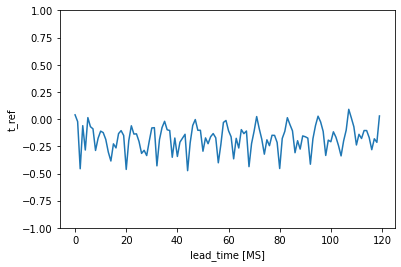

In [528]:
crpss(obsv_mon, fcst_mon, clim_probs_mon, period=TEST_PERIOD)['t_ref'].plot()
plt.ylim(-1,1)

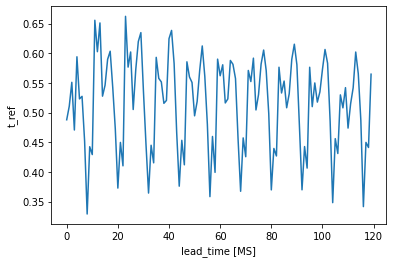

In [339]:
xs.crps_ensemble(
    my.mask_time_period(obsv_mon, period=TEST_PERIOD),
    my.mask_time_period(fcst_mon, period=TEST_PERIOD),
    member_dim='ensemble',
    dim='init_date')['t_ref'].plot()

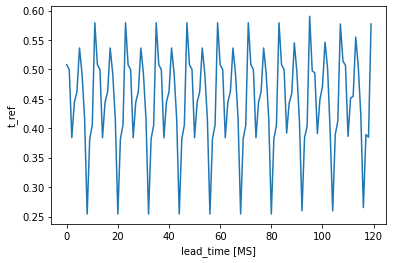

In [340]:
xs.crps_ensemble(
    my.mask_time_period(obsv_mon, period=TEST_PERIOD),
    my.mask_time_period(clim_probs, period=TEST_PERIOD),
    member_dim='ensemble',
    dim='init_date')['t_ref'].plot()

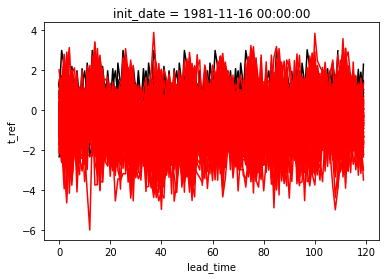

In [350]:
clim_probs['t_ref'].isel(init_date=0).plot.line(x='lead_time', color='k', add_legend=False);
fcst_mon['t_ref'].isel(init_date=0).plot.line(x='lead_time', color='r', add_legend=False);

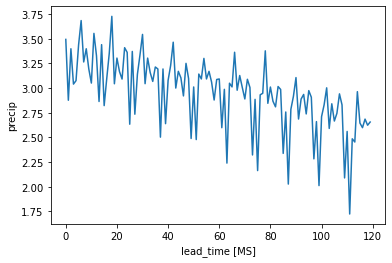

In [16]:
import numpy as np

xs.rps(
    my.mask_time_period(obsv, period=TEST_PERIOD),
    my.mask_time_period(fcst, period=TEST_PERIOD),
    category_edges=np.linspace(-50, 50, 20),
    member_dim='ensemble',
    dim='init_date')['precip'].plot()

In [25]:
obsv.min()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    precip   float64 5.684